# Predicting oil production using time series data.

In [7]:
import pandas as pd
import tensorflow as tf

from utils import create_sequences, build_model, balance_and_randomize, get_histogram, draw_well
from utils import check_feature_correlations, get_scatterplot
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error

tf.keras.backend.set_epsilon(1)  # important to descale mape metric
pd.options.mode.chained_assignment = None

## Data analysis

Load dataset and format it according to well type. We assign water injection features to each oil production well.

In [11]:
data = pd.read_csv('data/prod_data_train.csv')
data_op_wells = data[data['WELL_TYPE']=='OP']  # oil production
data_op_wells = data_op_wells.reset_index().drop(columns=['WAT_INJ'])
data_wi_wells = data[data['WELL_TYPE']=='WI']  # water injection

Draw wells production over time, alongside with water injection.

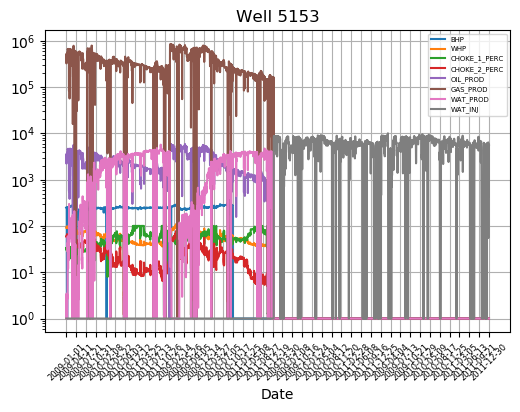

In [12]:
draw_well(data, '5153')

In [7]:
op_well_group = []
for grp1 in data_op_wells.groupby(['WELLNAME']):
    # Format current OP well
    g1 = grp1[1]
    g1['DATE'] = pd.to_datetime(g1['DATE'].values.reshape((-1,)).tolist())

    merged_df = g1
    for grp2 in data_wi_wells.groupby(['WELLNAME']):
        # Add water injection data to current OP well
        g2 = grp2[1][['DATE', 'WAT_INJ']]
        g2['DATE'] = pd.to_datetime(g2['DATE'].values.reshape((-1,)).tolist())
        merged_df = pd.merge(merged_df, g2, on='DATE')

    op_well_group.append(merged_df)

Define target variables and related features.

In [8]:
train_data = pd.concat(op_well_group, axis=0)
oil_prod = train_data['OIL_PROD'].values.reshape(-1, 1)
gas_prod = train_data['GAS_PROD'].values.reshape(-1, 1)
water_prod = train_data['WAT_PROD'].values.reshape(-1, 1)
features = train_data[['BHP', 'WHP', 'CHOKE_1_PERC', 'CHOKE_2_PERC', 'WAT_INJ_x', 'WAT_INJ_y']]

Check outliers and variable correlations. Drop the highly correlated ones.

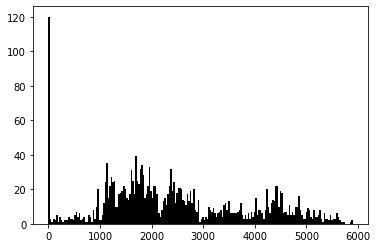

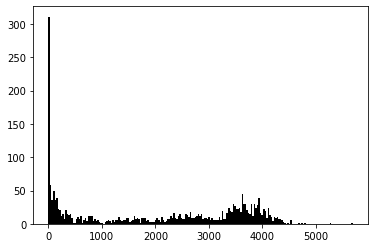

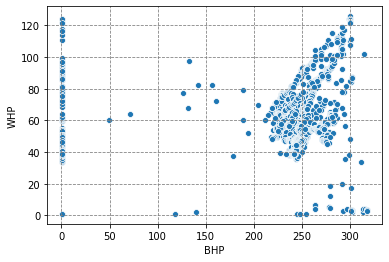

In [9]:
get_histogram(oil_prod, bins=200)
get_histogram(water_prod, bins=200)
get_scatterplot(features, x='BHP', y='WHP')

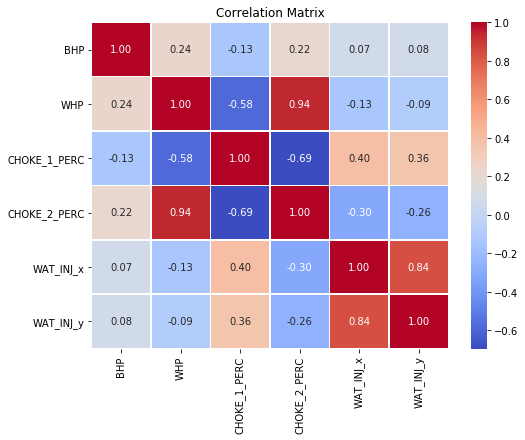

In [10]:
check_feature_correlations(features)
data_op_wells = data_op_wells.reset_index().drop(columns=['CHOKE_2_PERC'])
features_n = features.shape[1]

Define sequence length and split the data into training and testing sets, i.e. sequences of data values (time series) later used as input to a GRU learning model.

In [11]:
sequence_length = 10
X_op, y_op = create_sequences(features, oil_prod, sequence_length, nodata=1.)
X_wp, y_wp = create_sequences(features, water_prod, sequence_length, nodata=1.)

## Data formatting and training

### Oil production part

Rescale data within min-max range, then train and evaluate GRU model. Note that data sequences (sampled time seires) are re-sampled for data balancing purpose. To do so, we split data within different groups, e.g. by interval of re-scaled oil production values of 0.05, then estimate the maximum number of data features N among the interval groups. We later resample N data for each interval group. This is to avoid preferential sampling and biased training.

In [12]:
scaler = MinMaxScaler()
X_op_norm = scaler.fit_transform(X_op.reshape((-1, features_n))).reshape((-1, sequence_length, features_n))
y_op_norm = scaler.fit_transform(y_op)

X_balanced, y_balanced = balance_and_randomize(X_op_norm, y_op_norm, sequence_length, features_n)

split = int(0.8 * len(X_balanced))
X_train, X_test = X_balanced[:split], X_balanced[split:]
y_train, y_test = y_balanced[:split], y_balanced[split:]

model_op = build_model(sequence_length, features_n, 5e-4)
model_op.fit(X_train, y_train, epochs=200, batch_size=32, validation_split=0.1)
loss, mae, mape = model_op.evaluate(X_test, y_test)
print(f'Test Loss: {loss}, MAE: {mae}, MAPE: {mape}')

Epoch 1/200
36/36 [==============================] - 4s 27ms/step - loss: 0.0207 - mae: 0.1165 - mape: 11.6510 - val_loss: 0.0113 - val_mae: 0.0913 - val_mape: 9.1308
Epoch 2/200
36/36 [==============================] - 0s 12ms/step - loss: 0.0086 - mae: 0.0805 - mape: 8.0474 - val_loss: 0.0086 - val_mae: 0.0779 - val_mape: 7.7901
Epoch 3/200
36/36 [==============================] - 0s 13ms/step - loss: 0.0077 - mae: 0.0744 - mape: 7.4381 - val_loss: 0.0082 - val_mae: 0.0745 - val_mape: 7.4549
Epoch 4/200
36/36 [==============================] - 0s 12ms/step - loss: 0.0074 - mae: 0.0729 - mape: 7.2909 - val_loss: 0.0079 - val_mae: 0.0734 - val_mape: 7.3390
Epoch 5/200
36/36 [==============================] - 0s 12ms/step - loss: 0.0073 - mae: 0.0716 - mape: 7.1623 - val_loss: 0.0077 - val_mae: 0.0718 - val_mape: 7.1846
Epoch 6/200
36/36 [==============================] - 0s 11ms/step - loss: 0.0071 - mae: 0.0703 - mape: 7.0332 - val_loss: 0.0078 - val_mae: 0.0708 - val_mape: 7.0815
Epo

36/36 [==============================] - 0s 13ms/step - loss: 0.0015 - mae: 0.0256 - mape: 2.5568 - val_loss: 0.0021 - val_mae: 0.0305 - val_mape: 3.0548
Epoch 99/200
36/36 [==============================] - 0s 14ms/step - loss: 0.0014 - mae: 0.0256 - mape: 2.5569 - val_loss: 0.0019 - val_mae: 0.0284 - val_mape: 2.8441
Epoch 100/200
36/36 [==============================] - 0s 12ms/step - loss: 0.0014 - mae: 0.0255 - mape: 2.5492 - val_loss: 0.0019 - val_mae: 0.0298 - val_mape: 2.9758
Epoch 101/200
36/36 [==============================] - 0s 13ms/step - loss: 0.0014 - mae: 0.0255 - mape: 2.5548 - val_loss: 0.0019 - val_mae: 0.0318 - val_mape: 3.1832
Epoch 102/200
36/36 [==============================] - 0s 12ms/step - loss: 0.0014 - mae: 0.0255 - mape: 2.5476 - val_loss: 0.0020 - val_mae: 0.0300 - val_mape: 3.0003
Epoch 103/200
36/36 [==============================] - 0s 13ms/step - loss: 0.0014 - mae: 0.0244 - mape: 2.4433 - val_loss: 0.0021 - val_mae: 0.0316 - val_mape: 3.1595
Epoch 1

Epoch 147/200
36/36 [==============================] - 0s 12ms/step - loss: 8.8762e-04 - mae: 0.0192 - mape: 1.9249 - val_loss: 0.0013 - val_mae: 0.0249 - val_mape: 2.4940
Epoch 148/200
36/36 [==============================] - 1s 14ms/step - loss: 8.9019e-04 - mae: 0.0198 - mape: 1.9782 - val_loss: 0.0014 - val_mae: 0.0265 - val_mape: 2.6534
Epoch 149/200
36/36 [==============================] - 0s 12ms/step - loss: 8.3640e-04 - mae: 0.0191 - mape: 1.9072 - val_loss: 0.0013 - val_mae: 0.0241 - val_mape: 2.4113
Epoch 150/200
36/36 [==============================] - 1s 14ms/step - loss: 9.6669e-04 - mae: 0.0207 - mape: 2.0683 - val_loss: 0.0014 - val_mae: 0.0257 - val_mape: 2.5737
Epoch 151/200
36/36 [==============================] - 0s 12ms/step - loss: 9.0458e-04 - mae: 0.0204 - mape: 2.0403 - val_loss: 0.0012 - val_mae: 0.0229 - val_mape: 2.2856
Epoch 152/200
36/36 [==============================] - 0s 14ms/step - loss: 8.7652e-04 - mae: 0.0197 - mape: 1.9688 - val_loss: 0.0012 - val

Make predictions on the test set, and get the true values at original scale.

In [14]:
predictions = model_op.predict(X_test)
predictions_original_scale = scaler.inverse_transform(predictions)
y_test_original_scale = scaler.inverse_transform(y_test.reshape(-1, 1))
score_op = mean_absolute_percentage_error(y_test_original_scale, predictions_original_scale)
print('Oil production score is', score_op)

Oil production score is 0.11176502465646074


### Water production part

Proceed to same procedures as for the oil production part.

In [15]:
scaler = MinMaxScaler()
X_wp_norm = scaler.fit_transform(X_wp.reshape((-1, features_n))).reshape((-1, sequence_length, features_n))
y_wp_norm = scaler.fit_transform(y_wp)
X_balanced, y_balanced = balance_and_randomize(X_wp_norm, y_wp_norm, sequence_length, features_n)

split = int(0.8 * len(X_balanced))
X_train, X_test = X_balanced[:split], X_balanced[split:]
y_train, y_test = y_balanced[:split], y_balanced[split:]

model_wp = build_model(sequence_length, features_n, 5e-4)
model_wp.fit(X_train, y_train, epochs=200, batch_size=32, validation_split=0.1)
loss, mae, mape = model_wp.evaluate(X_test, y_test)
print(f'Test Loss: {loss}, MAE: {mae}, MAPE: {mape}')

Epoch 1/200
35/35 [==============================] - 3s 24ms/step - loss: 0.0574 - mae: 0.1837 - mape: 18.3684 - val_loss: 0.0081 - val_mae: 0.0736 - val_mape: 7.3605
Epoch 2/200
35/35 [==============================] - 0s 11ms/step - loss: 0.0050 - mae: 0.0593 - mape: 5.9260 - val_loss: 0.0038 - val_mae: 0.0527 - val_mape: 5.2739
Epoch 3/200
35/35 [==============================] - 0s 12ms/step - loss: 0.0038 - mae: 0.0539 - mape: 5.3885 - val_loss: 0.0035 - val_mae: 0.0511 - val_mape: 5.1131
Epoch 4/200
35/35 [==============================] - 0s 12ms/step - loss: 0.0035 - mae: 0.0519 - mape: 5.1852 - val_loss: 0.0032 - val_mae: 0.0496 - val_mape: 4.9580
Epoch 5/200
35/35 [==============================] - 0s 12ms/step - loss: 0.0032 - mae: 0.0497 - mape: 4.9699 - val_loss: 0.0031 - val_mae: 0.0490 - val_mape: 4.8986
Epoch 6/200
35/35 [==============================] - 0s 12ms/step - loss: 0.0030 - mae: 0.0480 - mape: 4.7978 - val_loss: 0.0030 - val_mae: 0.0470 - val_mape: 4.7004
Epo

35/35 [==============================] - 0s 11ms/step - loss: 5.4074e-04 - mae: 0.0178 - mape: 1.7806 - val_loss: 6.3155e-04 - val_mae: 0.0202 - val_mape: 2.0224
Epoch 98/200
35/35 [==============================] - 0s 9ms/step - loss: 5.3792e-04 - mae: 0.0178 - mape: 1.7798 - val_loss: 8.1325e-04 - val_mae: 0.0228 - val_mape: 2.2809
Epoch 99/200
35/35 [==============================] - 0s 13ms/step - loss: 5.7360e-04 - mae: 0.0184 - mape: 1.8360 - val_loss: 7.1152e-04 - val_mae: 0.0207 - val_mape: 2.0727
Epoch 100/200
35/35 [==============================] - 0s 11ms/step - loss: 6.4769e-04 - mae: 0.0196 - mape: 1.9592 - val_loss: 5.4336e-04 - val_mae: 0.0182 - val_mape: 1.8184
Epoch 101/200
35/35 [==============================] - 0s 11ms/step - loss: 4.8595e-04 - mae: 0.0170 - mape: 1.6982 - val_loss: 5.8116e-04 - val_mae: 0.0193 - val_mape: 1.9314
Epoch 102/200
35/35 [==============================] - 0s 12ms/step - loss: 5.1365e-04 - mae: 0.0173 - mape: 1.7257 - val_loss: 6.6018e-0

Epoch 144/200
35/35 [==============================] - 0s 11ms/step - loss: 3.7034e-04 - mae: 0.0147 - mape: 1.4672 - val_loss: 4.3169e-04 - val_mae: 0.0160 - val_mape: 1.6040
Epoch 145/200
35/35 [==============================] - 0s 12ms/step - loss: 3.3986e-04 - mae: 0.0141 - mape: 1.4072 - val_loss: 7.4752e-04 - val_mae: 0.0216 - val_mape: 2.1577
Epoch 146/200
35/35 [==============================] - 0s 12ms/step - loss: 4.4092e-04 - mae: 0.0160 - mape: 1.6020 - val_loss: 3.9990e-04 - val_mae: 0.0152 - val_mape: 1.5222
Epoch 147/200
35/35 [==============================] - 0s 11ms/step - loss: 3.4181e-04 - mae: 0.0138 - mape: 1.3809 - val_loss: 5.3732e-04 - val_mae: 0.0177 - val_mape: 1.7735
Epoch 148/200
35/35 [==============================] - 0s 12ms/step - loss: 4.0216e-04 - mae: 0.0154 - mape: 1.5417 - val_loss: 4.3433e-04 - val_mae: 0.0157 - val_mape: 1.5742
Epoch 149/200
35/35 [==============================] - 0s 12ms/step - loss: 3.3966e-04 - mae: 0.0141 - mape: 1.4072 - va

In [18]:
predictions = model_op.predict(X_test)
predictions_original_scale = scaler.inverse_transform(predictions)
y_test_original_scale = scaler.inverse_transform(y_test.reshape(-1, 1))
score_wp = mean_absolute_percentage_error(y_test_original_scale, predictions_original_scale)
print('Water production score is', score_wp)

Water production score is 25.603661565601005


# Total score on blind test

In [20]:
metric = 0.8 * score_op + 0.2 * score_wp
print('Overall solution metric is {:.4f}'.format(metric))

Overall solution metric is 5.2101
